In [123]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Settings
pd.set_option('display.max_columns', 500)



In [124]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
data_df=pd.concat([train_df, test_df])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [125]:
data_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [126]:
train_df.shape, test_df.shape, data_df.shape

((891, 12), (418, 11), (1309, 12))

In [127]:
OIR_columns =  ['Pclass','Age', 'Fare', 'SibSp', 'Parch']
data_df[OIR_columns].describe()

,Pclass,Age,Fare,SibSp,Parch
count,1309.000000,1046.000000,1308.000000,1309.000000,1309.000000
mean,2.294882,29.881138,33.295479,0.498854,0.385027
std,0.837836,14.413493,51.758668,1.041658,0.865560
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,7.895800,0.000000,0.000000
50%,3.000000,28.000000,14.454200,0.000000,0.000000
75%,3.000000,39.000000,31.275000,1.000000,0.000000
max,3.000000,80.000000,512.329200,8.000000,9.000000


In [128]:
def survival_rate(data, feature, graph_type):
    print(data[[feature, 'Survived']].groupby([feature], as_index=False).mean().sort_values(by='Survived'))
    sns.catplot(x=feature, y='Survived', data=data, kind=graph_type, height=6, aspect=1)\
        .set_ylabels('Survival Rate')\
            .ax.set_title(f'Survival Rate on {feature}', fontsize= 20)

In [129]:
data_df['title'] = data_df['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
data_df['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
the Countess      1
Jonkheer          1
Mme               1
Lady              1
Dona              1
Don               1
Sir               1
Capt              1
Name: title, dtype: int64

In [130]:
title_dic={
    'Mr':'Mr',
    'Miss':'Miss',
    'Mrs':'Mrs',
    'Master':'Master',
    'Dr':'Other',
    'Rev':'Other',
    'Mlle':'Miss',
    'Col': 'Other',
    'Major':'Other',
    'Sir':'Mr',
    'Mme':'Miss',
    'Jonkheer':'Other',
    'Lady':'Miss',
    'Capt':'Other',
    'Don':'Mr',
    'Dona':'Mrs',
    'Ms':'Miss',
    'the Countess':'Other'
}

    title  Survived
2      Mr  0.157996
4   Other  0.300000
0  Master  0.575000
1    Miss  0.705882
3     Mrs  0.792000


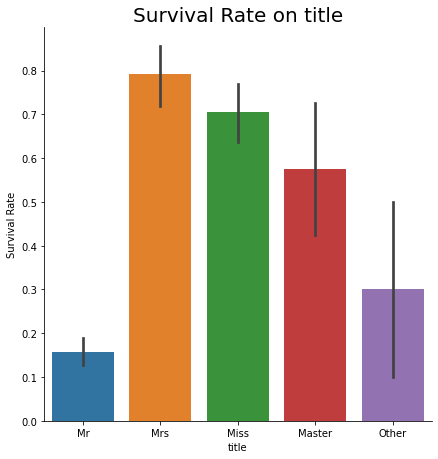

In [131]:
data_df['title'] = data_df['title'].map(title_dic)
survival_rate(data_df, 'title', 'bar')

In [132]:
irreleavan_columns = ['PassengerId', 'Name', 'Ticket']
data_preprocessed_df= data_df.drop(irreleavan_columns, axis=1)

In [133]:
data_preprocessed_df.replace('', float('NaN'),inplace=True)
data_preprocessed_df.replace(' ', float('NaN'),inplace=True)

In [134]:
count_missing_value=data_preprocessed_df.isna().sum() /data_preprocessed_df.shape[0]*100
count_missing_value_df=pd.DataFrame(count_missing_value.sort_values(ascending=False), columns=['Missing%'])


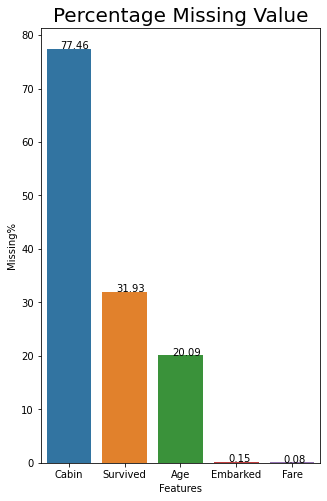

In [135]:
missing_value_df =count_missing_value_df[count_missing_value_df['Missing%'] >0]

plt.figure(figsize=(5,8))
missing_value_graph =sns.barplot(x=missing_value_df.index, y='Missing%', data=missing_value_df, orient='v')
missing_value_graph.set_title('Percentage Missing Value', fontsize=20)
missing_value_graph.set_xlabel('Features')
for p in missing_value_graph.patches:
    missing_value_graph.annotate(round(p.get_height(), 2), (p.get_x()+0.25, p.get_height()))


In [136]:
age_fig =go.Figure()
age_fig.add_trace(go.Box(
    y=data_preprocessed_df['Age'],
    name='Age',
    boxmean=True
))

age_fig.update_layout(
    height=600,
    width=800,
    title={
        'text':'The Distribution of Age',
        'font':{'size':24},
        'y':0.95,
        'x':0.5,
        'xanchor':'center',
        'yanchor':'top'},
        yaxis_title='Age'
)


In [137]:
fare_fig = go.Figure()
fare_fig.add_trace(go.Box(
                        y=data_preprocessed_df["Fare"],
                        name='Fare',
                        boxmean=True))

fare_fig.update_layout(
                height=600, 
                width=800,
                title={
                'text': "The Distribution of Fare",
                'font': {'size': 24},
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
                yaxis_title='Fare',
                )

fare_fig.show()

In [138]:
embarked_fig = px.histogram(data_preprocessed_df, x='Embarked')
embarked_fig.update_layout(
    height=600,
    width=800,
    title={
            'text': "The count of Embarked",
            'font': {'size': 24},
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
                )

embarked_fig.show()

In [139]:
data_preprocessed_df.groupby(data_preprocessed_df['Cabin'].isnull())['Survived'].mean()

Cabin
False    0.666667
True     0.299854
Name: Survived, dtype: float64

In [140]:
data_preprocessed_df['Cabin_indicator']= np.where(data_preprocessed_df['Cabin'].isnull(),0,1)
data_preprocessed_df.drop('Cabin',axis=1, inplace=True)
data_preprocessed_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,title,Cabin_indicator
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,0
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,0
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,1
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,0
...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,male,NaN,0,0,8.0500,S,Mr,0
414,NaN,1,female,39.0,0,0,108.9000,C,Mrs,1
415,NaN,3,male,38.5,0,0,7.2500,S,Mr,0
416,NaN,3,male,NaN,0,0,8.0500,S,Mr,0


Text(0.5, 1.0, 'Pearson Correlation')

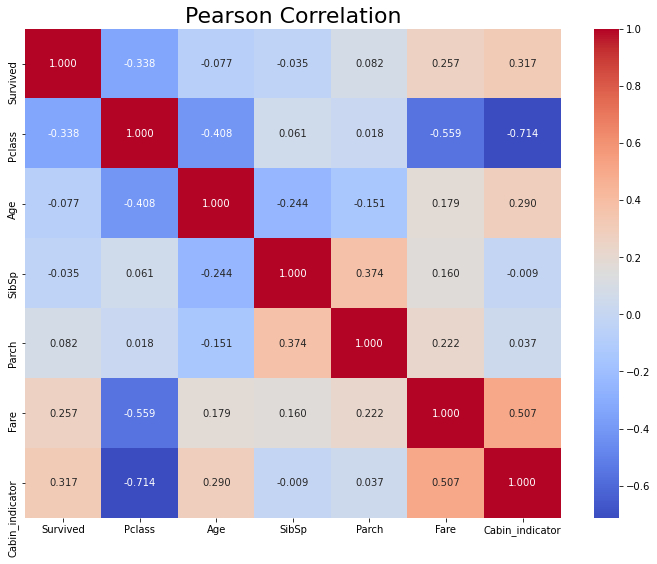

In [141]:
plt.figure(figsize=(12,9))
sns.heatmap(data_preprocessed_df.corr(),cmap='coolwarm', annot= True, fmt='.3f').set_title('Pearson Correlation', fontsize=22)

In [142]:
data_preprocessed_median_df = data_preprocessed_df.copy()
data_preprocessed_median_df["Age"].fillna(data_preprocessed_median_df.groupby(['Pclass','Sex'])['Age'].transform("median"), inplace=True)
data_preprocessed_median_df['Fare'] = data_preprocessed_df['Fare'].fillna(data_preprocessed_df['Fare'].median())

In [143]:
data_preprocessed_median_df['Embarked'].fillna(data_preprocessed_median_df['Embarked'].mode()[0], inplace=True)
# Check Missing value for
print(f'Missing value:\n Median imputation: {sum(data_preprocessed_median_df.isna().sum())}')

Missing value:
 Median imputation: 418


In [144]:
data_preprocessed_median_df['AgeBin'] = pd.cut(data_preprocessed_median_df['Age'].astype(int), 5, labels=['a', 'b', 'c', 'd','e'])
data_preprocessed_median_df['FareBin'] = pd.cut(data_preprocessed_median_df['Fare'].astype(int), 4, labels=['a', 'b', 'c', 'd'])



In [145]:
data_best_df = data_preprocessed_median_df.iloc[:891].copy()

In [146]:
survival_counts = data_best_df["Survived"].value_counts()
survival_counts_df = pd.DataFrame(survival_counts)

In [147]:
survival_fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{"type": "xy"}, {"type": "domain"}]])

survival_fig.add_trace(go.Bar(x=survival_counts_df.index, 
                              y=survival_counts_df["Survived"],
                              text=survival_counts_df["Survived"],
                              textposition='outside',
                              showlegend=False),
                              1, 1)

survival_fig.add_trace(go.Pie(labels=survival_counts_df.index, 
                     values=survival_counts_df["Survived"],
                     showlegend=True),
                     1, 2)

survival_fig.update_layout(
                  height=600, 
                  width=1000,
                  title={
                  'text': "The distribution of Survival",
                  'font': {'size': 24},
                  'y':0.95,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                  xaxis1_title = 'Survived', 
                  yaxis1_title = 'Counts',
                  legend_title_text="Survived"
                 )
survival_fig.update_xaxes(type='category')
survival_fig.show()

In [148]:
def categorical_VIS(data, feature):
    
    # Calculate the distribution of the chosen feature
    survived = data[data["Survived"] == 1][feature]
    survived_df = pd.DataFrame(survived.value_counts())
    not_survived = data[data["Survived"] == 0][feature]
    not_survived_df = pd.DataFrame(not_survived.value_counts())
    
    # Visualization
    survival_fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Survived", "Non-Survived"),
    specs=[[{"type": "domain"}, {"type": "domain"}]])
    survival_fig.add_trace(go.Pie(labels=survived_df.index, 
                     values=survived_df[feature],
                     showlegend=True),
                     1, 1)
    survival_fig.add_trace(go.Pie(labels=not_survived_df.index, 
                     values=not_survived_df[feature],
                     showlegend=True),
                     1, 2)
    survival_fig.update_layout(
                  height=600, 
                  width=1000,
                  title={
                  'text': "The Distribution of "+ feature + " on Survival",
                  'font': {'size': 24},
                  'y':0.95,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                  legend_title_text=feature
                 )
    survival_fig.update_xaxes(type='category')
    survival_fig.show()

In [149]:
categorical_VIS(data_best_df, "Sex")

      Sex  Survived
1    male  0.188908
0  female  0.742038


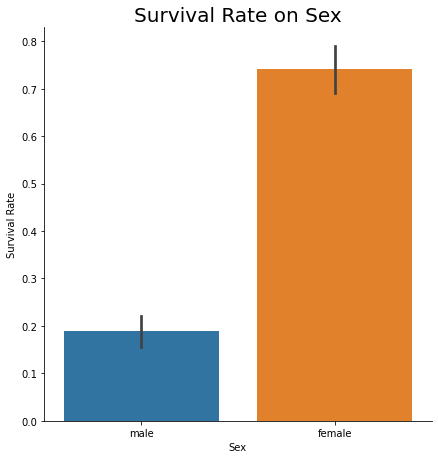

In [150]:
survival_rate(data_best_df, 'Sex', 'bar')

In [151]:
categorical_VIS(data_best_df, "Pclass")

   Pclass  Survived
2       3  0.242363
1       2  0.472826
0       1  0.629630


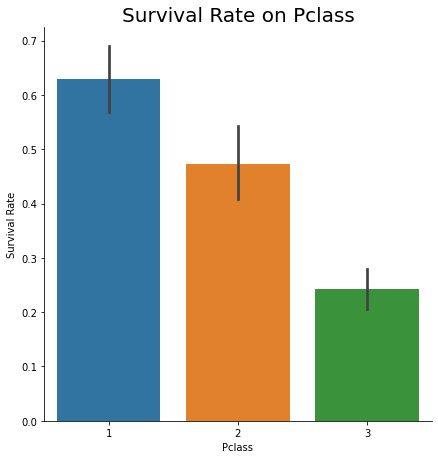

In [152]:
survival_rate(data_best_df, 'Pclass', 'bar')

In [153]:
categorical_VIS(data_best_df, "SibSp")

   SibSp  Survived
5      5  0.000000
6      8  0.000000
4      4  0.166667
3      3  0.250000
0      0  0.345395
2      2  0.464286
1      1  0.535885


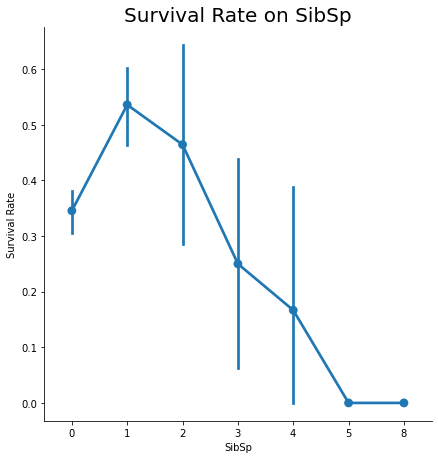

In [154]:
survival_rate(data_best_df, 'SibSp', 'point')

In [155]:
categorical_VIS(data_best_df, "Parch")

   Parch  Survived
4      4  0.000000
6      6  0.000000
5      5  0.200000
0      0  0.343658
2      2  0.500000
1      1  0.550847
3      3  0.600000


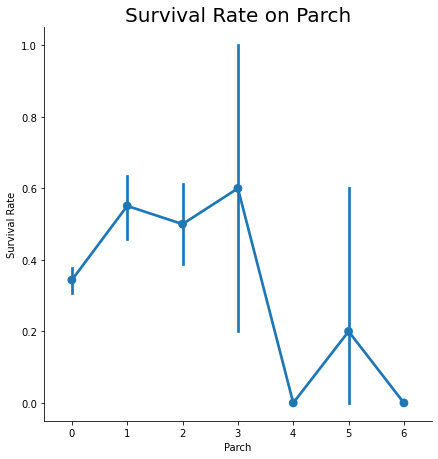

In [156]:
survival_rate(data_best_df, 'Parch', 'point')

In [157]:
categorical_VIS(data_best_df, "Embarked")

  Embarked  Survived
2        S  0.339009
1        Q  0.389610
0        C  0.553571


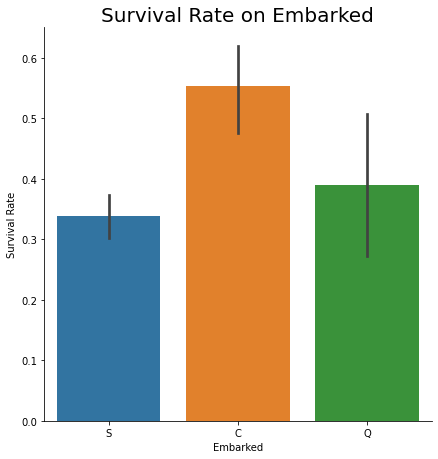

In [158]:
survival_rate(data_best_df, 'Embarked', 'bar')

In [159]:
age_fig = px.box(data_best_df, x="Survived", y="Age")
age_fig.update_layout(
                  height=600, 
                  width=1000,
                  title={
                  'text': "The Distribution of Age on Survival",
                  'font': {'size': 24},
                  'y':0.95,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                  legend_title_text="Survived"
                 )

  AgeBin  Survived
4      e  0.090909
1      b  0.337374
2      c  0.412037
3      d  0.434783
0      a  0.550000


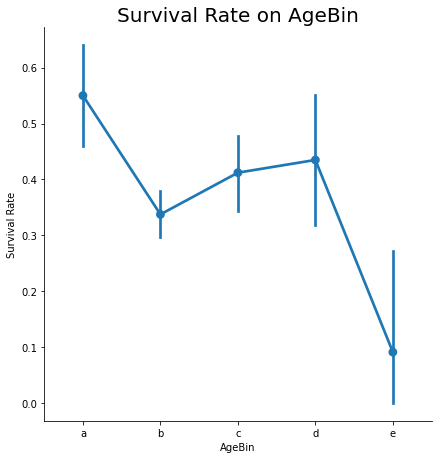

In [160]:
survival_rate(data_best_df, 'AgeBin', 'point')

In [161]:
fare_fig = px.box(data_best_df, x="Survived", y="Fare")
fare_fig.update_layout(
                  height=600, 
                  width=1000,
                  title={
                  'text': "The Distribution of Fare on Survival",
                  'font': {'size': 24},
                  'y':0.95,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                  legend_title_text="Survived"
                 )

  FareBin  Survived
0       a  0.368113
2       c  0.666667
1       b  0.724138
3       d  1.000000


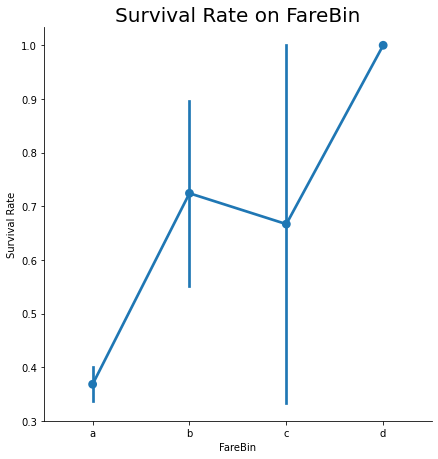

In [162]:
# Calcute the survival Rate
survival_rate(data_best_df, 'FareBin', 'point')

   Family_size  Survived
7            8  0.000000
8           11  0.000000
5            6  0.136364
4            5  0.200000
0            1  0.303538
6            7  0.333333
1            2  0.552795
2            3  0.578431
3            4  0.724138


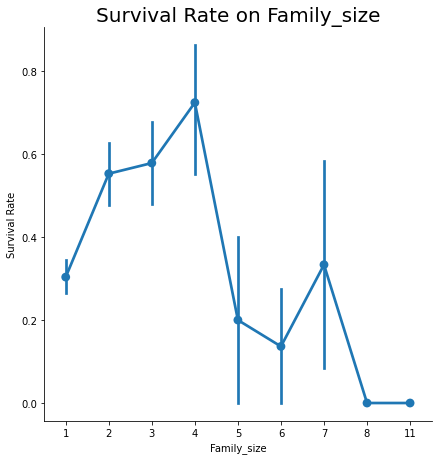

In [163]:
data_best_df['Family_size'] = data_best_df['SibSp'] + data_best_df['Parch'] + 1
survival_rate(data_best_df, 'Family_size', 'point')

In [164]:
data_best_df.loc[data_best_df['Family_size'] == 1, 'Family_size'] = 0 # Alone
data_best_df.loc[(data_best_df['Family_size'] > 1) & (data_best_df['Family_size'] <= 4), 'Family_size'] = 1  # Small Family 
data_best_df.loc[(data_best_df['Family_size'] > 4) & (data_best_df['Family_size'] <= 6), 'Family_size'] = 2  # Medium Family
data_best_df.loc[data_best_df['Family_size']  > 6, 'Family_size'] = 3 # Large Family

In [165]:
# Feature SibSp and Parch are replaced by Family_size
data_best_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [166]:
# Feature Age and Fare are replaced by AgeBin and FareBin
data_best_df.drop(['Age', 'Fare'], axis=1, inplace=True)

In [167]:
# Select features that are suitable for One Hot Encoding
onehot_features = ["Embarked","title"]
onehot_df = pd.get_dummies(data_best_df[onehot_features])
data_best_df.drop(onehot_features, axis=1, inplace=True)
data_best_df = pd.concat([data_best_df, onehot_df], axis=1)

In [168]:
# Select features that are suitable for Label Encoding
data_best_df["Sex"]  = LabelEncoder().fit_transform(data_best_df["Sex"])
data_best_df["AgeBin"]  = LabelEncoder().fit_transform(data_best_df["AgeBin"])
data_best_df["FareBin"]  = LabelEncoder().fit_transform(data_best_df["FareBin"])

In [169]:
data_best_df

,Survived,Pclass,Sex,Cabin_indicator,AgeBin,FareBin,Family_size,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other
0,0.0,3,1,0,1,0,1,0,0,1,0,0,1,0,0
1,1.0,1,0,1,2,0,1,1,0,0,0,0,0,1,0
2,1.0,3,0,0,1,0,0,0,0,1,0,1,0,0,0
3,1.0,1,0,1,2,0,1,0,0,1,0,0,0,1,0
4,0.0,3,1,0,2,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,0,1,0,0,0,0,1,0,0,0,0,1
887,1.0,1,0,1,1,0,0,0,0,1,0,1,0,0,0
888,0.0,3,0,0,1,0,1,0,0,1,0,1,0,0,0
889,1.0,1,1,1,1,0,0,1,0,0,0,0,1,0,0
